In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [ ]:
from utils.data_handling import *
from utils.sensor_optimisation import *
from parameters import *
import GPy
import scipy.stats
from sklearn.covariance import *
import time



import matplotlib.pyplot as plt
np.random.seed(101)




### Importing the Tracer Data to Select the Optimisation set S

In [4]:
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0, 'i_end': 988, 'crop': None, 'field_name': 'Tracer'}

In [5]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


### Working subset of the data : set S

In [6]:
S_human = human_level_subset(buildingshape, loc_df, 2,1 )
print("The remaining number of points is : ", str(len(S_human)))

The remaining number of points is :  37847


In [7]:
S_working = working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-2 )
print("The remaining number of points is : ", str(len(S_working)))

The remaining number of points is :  57725


In [8]:
S = np.intersect1d(S_human,S_working)
print("The remaining number of points is : ", str(len(S)))

The remaining number of points is :  23643


In [9]:
#A_list = set_to_onehot(S,data_df.shape[0])
#save_vtu(ref_vtu[0],'FinalSelection',A_list)

### Import the Field of interest for computing the optimisation : TracerBackground / Pressure

In [10]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0, 'i_end': 988, 'crop': None, 'field_name': 'Tracer'}

In [11]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

  0%|          | 0/1 [00:00<?, ?it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


In [12]:
X = loc_df.values[:,:] #[I,:dim]
Z = data_df.values[:,:] #[:,t].reshape(-1,1) # [I,t].reshape(-1,1)
Z.shape

(100040, 989)

### Detrending Data : 
Plotting the data along each direction in order to see if there is a obvious trend. It seams that it is not the case. 

In [13]:
#Z[S,:] = (Z[S,:]  - Z[S,:].mean(axis=1,keepdims=True))

### Sample Covariance

In [14]:
cov_emp = empirical_covariance(Z[S,:].T)

In [15]:
np.linalg.slogdet(cov_emp)

(1.0, -1399932.5637581607)

In [16]:
eig_emp = np.linalg.eigvalsh(cov_emp)
eig_emp[-1]

0.021915655570946678

In [17]:
eig_emp[0]

-6.773178779857725e-18

Text(0, 0.5, 'Eigenvalues $\\lambda_i$')

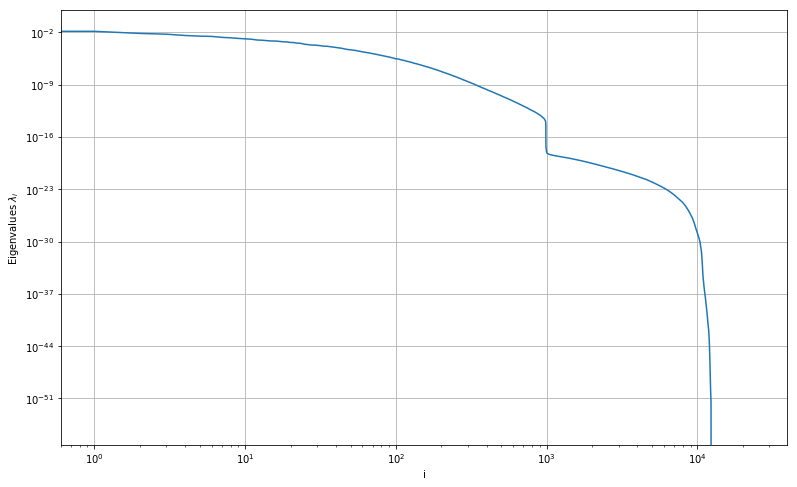

In [18]:
plt.figure(figsize=(13,8))
plt.loglog(eig_emp[::-1])
plt.grid()
plt.xlabel("i")
plt.ylabel("Eigenvalues $\lambda_i$")

### OAS Covariance

In [19]:
cov, shrinkage_coef = oas(Z[S,:].T)
cov.shape

(23643, 23643)

KeyboardInterrupt: 

In [20]:
np.linalg.slogdet(cov)

(1.0, -408903.3383689513)

In [ ]:
eig_oas = np.linalg.eigvalsh(cov)


In [ ]:
eig_oas[0]

2.943502753067013e-08

Text(0, 0.5, 'Eigenvalues $\\lambda_i$')

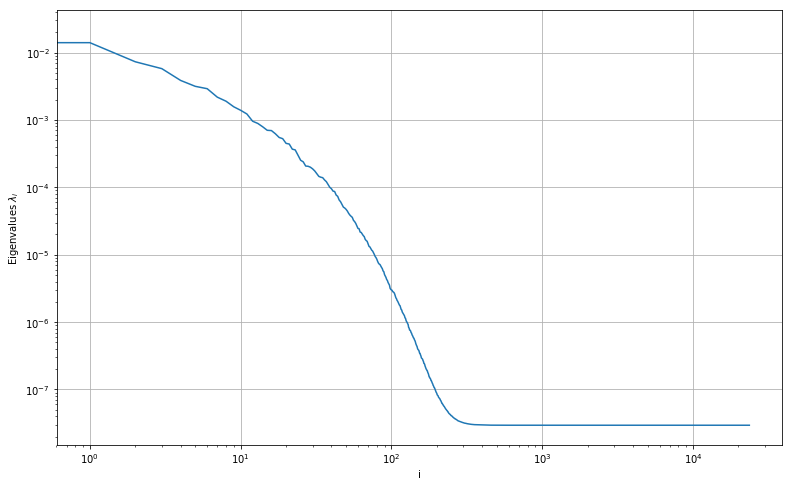

In [ ]:
plt.figure(figsize=(13,8))
plt.loglog(eig_oas[::-1])
plt.grid()
plt.xlabel("i")
plt.ylabel("Eigenvalues $\lambda_i$")

### Sensor Optimisation with 3rd Algorithm : 


Define the Sets for the optimisation

In [ ]:
sets = define_sets(S)

Number of sensors to place : 

In [ ]:
k = 10

In [ ]:
A_opt = {}

Truncation parameteter for the local covariance : 

In [ ]:
epsilon = 10**-6 # 10
print(epsilon)

1e-06


In [ ]:
start = time.time()
A_opt['local_eps_10^-6'] = sensor_loc_optimisation_naive_local(k,cov, "threshold", epsilon, sets)
end = time.time()

Init Loop:  42%|████▏     | 9946/23643 [24:47<25:53,  8.82it/s]  

In [35]:
A_opt['local_eps_10^-6'] 

(array([56588, 52731, 73959, 43278,  3078, 19782, 56257, 55640, 10357,
        54786]), [4338, 4938, 5066, 5362, 4239, 4164, 3377, 4632, 3511, 4120])

In [ ]:
end-start

In [ ]:
A, d_opt = A_opt['local_eps_10^-6'] 
A

In [ ]:
print(loc_df.loc[A,:].T.to_latex(float_format="%.2f"))

In [47]:
idx_A = [i  for i in range(len(S)) if S[i] in A]
S[idx_A] == np.sort(A)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

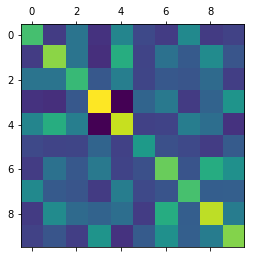

In [62]:
plt.matshow(cov[np.ix_(idx_A,idx_A)])

In [63]:
np.savetxt('Optimal Points/V_oas',scipy.linalg.sqrtm(cov[np.ix_(idx_A,idx_A)]) )

In [59]:
A_old = [38726, 14276, 91348,  5338, 40994, 29626, 65851, 65734,   851, 2293]


In [61]:
dist_set(A_old,A, loc_df)/10

13.84812179921324

In [33]:
A_list = set_to_onehot(A,data_df.shape[0])
save_vtu(ref_vtu,'Opt_3rd_eps_10-6',A_list)

==> Saved to : ../data/temp_data/LSBU_res_2019:08:13-09:18:03_Opt_3rd_eps_10-6.vtu


In [27]:
d = 1500

In [29]:
A_opt['local'] = sensor_loc_optimisation_naive_local(k,cov, "fixed", d, sets)

Init Loop:   0%|          | 0/23643 [00:00<?, ?it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 1/23643 [00:00<1:12:11,  5.46it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 2/23643 [00:00<1:05:44,  5.99it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 3/23643 [00:00<1:01:07,  6.45it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 4/23643 [00:00<58:00,  6.79it/s]  

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 5/23643 [00:00<55:45,  7.07it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 6/23643 [00:00<54:08,  7.28it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 7/23643 [00:00<52:57,  7.44it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 8/23643 [00:01<52:11,  7.55it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 9/23643 [00:01<51:32,  7.64it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 10/23643 [00:01<51:03,  7.72it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 11/23643 [00:01<50:40,  7.77it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 12/23643 [00:01<50:27,  7.80it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 13/23643 [00:01<50:18,  7.83it/s]

Length of local covariance set : d =  1500 , largest =  [[0.]]  smallest = [[0.]]


Init Loop:   0%|          | 14/23643 [00:01<50:14,  7.84it/s]

Length of local covariance set : d =  10 , largest =  [[0.30274981]]  smallest = [[-0.12215276]]
Length of local covariance set : d =  1500 , largest =  [[0.41373662]]  smallest = [[0.1687729]]



Inner Loop : placing sensor 10:  58%|█████▊    | 13796/23633 [03:09<04:38, 35.38it/s]

Length of local covariance set : d =  10 , largest =  [[0.54027553]]  smallest = [[-0.46475479]]
Length of local covariance set : d =  1500 , largest =  [[0.52865215]]  smallest = [[0.04358664]]



Inner Loop : placing sensor 10:  58%|█████▊    | 13803/23633 [03:09<04:51, 33.67it/s]

Length of local covariance set : d =  10 , largest =  [[0.57244502]]  smallest = [[-0.05548374]]
Length of local covariance set : d =  1500 , largest =  [[0.60465796]]  smallest = [[0.12839824]]



Inner Loop : placing sensor 10:  58%|█████▊    | 13814/23633 [03:10<04:25, 36.93it/s]

Length of local covariance set : d =  10 , largest =  [[0.51783182]]  smallest = [[-0.18363716]]
Length of local covariance set : d =  1500 , largest =  [[0.59649114]]  smallest = [[0.07617548]]



Inner Loop : placing sensor 10:  58%|█████▊    | 13819/23633 [03:10<05:21, 30.51it/s]

Length of local covariance set : d =  10 , largest =  [[0.3310235]]  smallest = [[-0.04050324]]
Length of local covariance set : d =  1500 , largest =  [[0.34016959]]  smallest = [[0.16541603]]



Inner Loop : placing sensor 10:  59%|█████▊    | 13844/23633 [03:10<04:12, 38.75it/s]

Length of local covariance set : d =  10 , largest =  [[0.26160142]]  smallest = [[-0.08738278]]
Length of local covariance set : d =  1500 , largest =  [[0.27856162]]  smallest = [[0.10426817]]



Inner Loop : placing sensor 10:  59%|█████▊    | 13850/23633 [03:10<04:50, 33.68it/s]

Length of local covariance set : d =  10 , largest =  [[0.16912241]]  smallest = [[-0.10945697]]
Length of local covariance set : d =  1500 , largest =  [[0.2601461]]  smallest = [[0.04928444]]
Length of local covariance set : d =  10 , largest =  [[0.16027545]]  smallest = [[-0.18198048]]
Length of local covariance set : d =  1500 , largest =  [[0.2252526]]  smallest = [[0.03992482]]



Inner Loop : placing sensor 10:  59%|█████▊    | 13855/23633 [03:11<07:48, 20.86it/s]

Length of local covariance set : d =  10 , largest =  [[0.13639329]]  smallest = [[-0.15445659]]
Length of local covariance set : d =  1500 , largest =  [[0.16960536]]  smallest = [[0.03799507]]



Inner Loop : placing sensor 10:  59%|█████▊    | 13859/23633 [03:11<08:19, 19.58it/s]

Length of local covariance set : d =  10 , largest =  [[0.50666724]]  smallest = [[-0.04506847]]
Length of local covariance set : d =  1500 , largest =  [[0.60997637]]  smallest = [[0.16831819]]



Inner Loop : placing sensor 10:  59%|█████▊    | 13867/23633 [03:11<07:12, 22.56it/s]

Length of local covariance set : d =  10 , largest =  [[0.36394487]]  smallest = [[-0.10243482]]
Length of local covariance set : d =  1500 , largest =  [[0.41687064]]  smallest = [[0.0897063]]



Inner Loop : placing sensor 10:  59%|█████▊    | 13871/23633 [03:11<07:46, 20.91it/s]

Length of local covariance set : d =  10 , largest =  [[0.21535326]]  smallest = [[-0.08002491]]
Length of local covariance set : d =  1500 , largest =  [[0.26906942]]  smallest = [[0.12036273]]



Inner Loop : placing sensor 10:  59%|█████▉    | 13922/23633 [03:12<05:39, 28.57it/s]

Length of local covariance set : d =  10 , largest =  [[0.10613224]]  smallest = [[-0.06609756]]
Length of local covariance set : d =  1500 , largest =  [[0.11876879]]  smallest = [[0.03450501]]



Inner Loop : placing sensor 10:  59%|█████▉    | 13933/23633 [03:12<04:58, 32.45it/s]

Length of local covariance set : d =  10 , largest =  [[0.10796103]]  smallest = [[-0.07853878]]
Length of local covariance set : d =  1500 , largest =  [[0.11474338]]  smallest = [[0.02870368]]
Length of local covariance set : d =  10 , largest =  [[0.19203954]]  smallest = [[-0.05270429]]
Length of local covariance set : d =  1500 , largest =  [[0.2128574]]  smallest = [[0.08609399]]



Inner Loop : placing sensor 10:  59%|█████▉    | 13940/23633 [03:12<06:38, 24.32it/s]

Length of local covariance set : d =  10 , largest =  [[0.31171988]]  smallest = [[-0.14177212]]
Length of local covariance set : d =  1500 , largest =  [[0.38968556]]  smallest = [[0.04998317]]



Inner Loop : placing sensor 10:  59%|█████▉    | 13950/23633 [03:13<05:52, 27.45it/s]

Length of local covariance set : d =  10 , largest =  [[0.46395276]]  smallest = [[-0.35167351]]
Length of local covariance set : d =  1500 , largest =  [[0.53066565]]  smallest = [[0.0470507]]



Inner Loop : placing sensor 10:  59%|█████▉    | 13955/23633 [03:13<06:23, 25.22it/s]

Length of local covariance set : d =  10 , largest =  [[0.09806723]]  smallest = [[-0.10145834]]
Length of local covariance set : d =  1500 , largest =  [[0.12124828]]  smallest = [[0.04783554]]



Inner Loop : placing sensor 10:  59%|█████▉    | 13963/23633 [03:13<05:51, 27.51it/s]

Length of local covariance set : d =  10 , largest =  [[0.36867278]]  smallest = [[-0.01428464]]
Length of local covariance set : d =  1500 , largest =  [[0.43420401]]  smallest = [[0.21350244]]



Inner Loop : placing sensor 10:  59%|█████▉    | 13974/23633 [03:13<05:06, 31.53it/s]

Length of local covariance set : d =  10 , largest =  [[0.06865454]]  smallest = [[-0.08566779]]
Length of local covariance set : d =  1500 , largest =  [[0.07762155]]  smallest = [[0.02220189]]



Inner Loop : placing sensor 10:  59%|█████▉    | 13983/23633 [03:14<04:49, 33.36it/s]

Length of local covariance set : d =  10 , largest =  [[0.11965382]]  smallest = [[-0.1234879]]
Length of local covariance set : d =  1500 , largest =  [[0.15078449]]  smallest = [[0.05330648]]



Inner Loop : placing sensor 10:  59%|█████▉    | 14000/23633 [03:14<04:02, 39.77it/s]

Length of local covariance set : d =  10 , largest =  [[0.26949554]]  smallest = [[-0.05133307]]
Length of local covariance set : d =  1500 , largest =  [[0.26527153]]  smallest = [[0.10543927]]



Inner Loop : placing sensor 10:  59%|█████▉    | 14025/23633 [03:14<03:16, 48.80it/s]

Length of local covariance set : d =  10 , largest =  [[0.07984087]]  smallest = [[-0.06295174]]
Length of local covariance set : d =  1500 , largest =  [[0.10750635]]  smallest = [[0.05271643]]
Length of local covariance set : d =  10 , largest =  [[0.10133932]]  smallest = [[-0.20655393]]
Length of local covariance set : d =  1500 , largest =  [[0.10739928]]  smallest = [[0.02083079]]



Inner Loop : placing sensor 10:  59%|█████▉    | 14032/23633 [03:14<05:25, 29.51it/s]

Length of local covariance set : d =  10 , largest =  [[0.1542409]]  smallest = [[-0.05576728]]
Length of local covariance set : d =  1500 , largest =  [[0.17219799]]  smallest = [[0.07693223]]



Inner Loop : placing sensor 10:  59%|█████▉    | 14044/23633 [03:15<04:43, 33.79it/s]

Length of local covariance set : d =  10 , largest =  [[0.10062672]]  smallest = [[-0.12614009]]
Length of local covariance set : d =  1500 , largest =  [[0.09753316]]  smallest = [[0.01926568]]



Inner Loop : placing sensor 10:  59%|█████▉    | 14055/23633 [03:15<04:20, 36.81it/s]

Length of local covariance set : d =  10 , largest =  [[0.53501559]]  smallest = [[-0.05767168]]
Length of local covariance set : d =  1500 , largest =  [[0.59103542]]  smallest = [[0.16169737]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14072/23633 [03:15<03:41, 43.18it/s]

Length of local covariance set : d =  10 , largest =  [[0.08249781]]  smallest = [[-0.06717319]]
Length of local covariance set : d =  1500 , largest =  [[0.12800586]]  smallest = [[0.06006607]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14085/23633 [03:15<03:25, 46.38it/s]

Length of local covariance set : d =  10 , largest =  [[0.1309389]]  smallest = [[0.01956671]]
Length of local covariance set : d =  1500 , largest =  [[0.13272112]]  smallest = [[0.05380538]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14103/23633 [03:16<03:01, 52.38it/s]

Length of local covariance set : d =  10 , largest =  [[0.21486684]]  smallest = [[-0.09402773]]
Length of local covariance set : d =  1500 , largest =  [[0.22016661]]  smallest = [[0.04790931]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14117/23633 [03:16<02:56, 54.07it/s]

Length of local covariance set : d =  10 , largest =  [[0.48404203]]  smallest = [[-0.08941359]]
Length of local covariance set : d =  1500 , largest =  [[0.49208499]]  smallest = [[0.17163935]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14124/23633 [03:16<03:37, 43.68it/s]

Length of local covariance set : d =  10 , largest =  [[0.20609613]]  smallest = [[-0.08063424]]
Length of local covariance set : d =  1500 , largest =  [[0.21124219]]  smallest = [[0.04908798]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14141/23633 [03:16<03:13, 49.09it/s]

Length of local covariance set : d =  10 , largest =  [[0.26236772]]  smallest = [[-0.12543257]]
Length of local covariance set : d =  1500 , largest =  [[0.27419169]]  smallest = [[0.04411409]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14147/23633 [03:17<04:06, 38.41it/s]

Length of local covariance set : d =  10 , largest =  [[0.20549547]]  smallest = [[-0.12492871]]
Length of local covariance set : d =  1500 , largest =  [[0.21006922]]  smallest = [[0.06797448]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14152/23633 [03:17<05:08, 30.77it/s]

Length of local covariance set : d =  10 , largest =  [[0.0929167]]  smallest = [[-0.18117815]]
Length of local covariance set : d =  1500 , largest =  [[0.26012918]]  smallest = [[0.02180908]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14160/23633 [03:17<05:10, 30.49it/s]

Length of local covariance set : d =  10 , largest =  [[0.25802418]]  smallest = [[-0.12273152]]
Length of local covariance set : d =  1500 , largest =  [[0.26252448]]  smallest = [[0.05562739]]



Inner Loop : placing sensor 10:  60%|█████▉    | 14175/23633 [03:17<04:23, 35.89it/s]

Length of local covariance set : d =  10 , largest =  [[0.42089029]]  smallest = [[-0.29810057]]
Length of local covariance set : d =  1500 , largest =  [[0.51912071]]  smallest = [[0.17367415]]



Inner Loop : placing sensor 10:  60%|██████    | 14185/23633 [03:18<04:12, 37.49it/s]

Length of local covariance set : d =  10 , largest =  [[0.06224838]]  smallest = [[-0.00676827]]
Length of local covariance set : d =  1500 , largest =  [[0.12153858]]  smallest = [[0.05196114]]



Inner Loop : placing sensor 10:  60%|██████    | 14201/23633 [03:18<03:37, 43.29it/s]

Length of local covariance set : d =  10 , largest =  [[0.26457332]]  smallest = [[-0.11328641]]
Length of local covariance set : d =  1500 , largest =  [[0.29922622]]  smallest = [[0.12262201]]



Inner Loop : placing sensor 10:  60%|██████    | 14215/23633 [03:18<03:19, 47.23it/s]

Length of local covariance set : d =  10 , largest =  [[0.54492111]]  smallest = [[-0.6751463]]
Length of local covariance set : d =  1500 , largest =  [[0.57896016]]  smallest = [[0.00875287]]



Inner Loop : placing sensor 10:  60%|██████    | 14221/23633 [03:18<04:20, 36.15it/s]

Length of local covariance set : d =  10 , largest =  [[0.71068794]]  smallest = [[-0.14869289]]
Length of local covariance set : d =  1500 , largest =  [[0.7343475]]  smallest = [[0.28236582]]



Inner Loop : placing sensor 10:  60%|██████    | 14237/23633 [03:19<03:44, 41.89it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
A_opt['local']

KeyError: 'local'

In [37]:
A_opt['lazy'] = sensor_loc_optimisation_lazy(k,Z, sets, tau)

NameError: name 'tau' is not defined

In [38]:
A_opt['naive'] = sensor_loc_optimisation_naive(k,Z, sets)

IndexError: index 991 is out of bounds for axis 1 with size 989

In [ ]:
A_opt['lazy'] 

In [ ]:
A_opt['naive']

In [138]:
S = np.random.random_integers(0,300,size=(10,1))

In [139]:
n_S = len(S)

In [23]:
"Inner Loop : placing sensor " + str(10+1)

'Inner Loop : placing sensor 11'

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[[225], [230], [244], [112], [246], [28], [144], [238], [269], [213]]

In [158]:
y_opt = max(delta_y, key=delta_y.get)

In [161]:
delta_y.pop(y_opt)

KeyError: 230

In [58]:
A_opt['local_weird']  = A_opt['local'] 

In [61]:
A_opt['local_weird']


array([56588, 19615, 34380, 10357, 19782])

In [79]:
A_list = set_to_onehot(A_opt['local'] ,data_df.shape[0])
save_vtu(ref_vtu[0],'Opt10Alg3_d1500',A_list)

==> Saved to : ../data/temp_data/LSBU_res_2019:08:06-08:59:56_Opt10Alg3_d1500.vtu


In [62]:
A_opt['local'] 

array([56588, 19615, 34380, 10357, 19782])

In [64]:
loc_df.loc[A_opt['local'] ]

,X,Y,Z
56588,41.612950,27.211039,16.725003
19615,63.921767,39.719012,1.082953
34380,30.229359,26.034682,12.134716
10357,62.126762,45.229813,1.635897
19782,38.747350,35.258986,1.799108


In [76]:
A_opt['local']

array([56588, 19615, 34380, 10357, 19782, 43278, 32853, 43412,  7183,
        3903])

In [78]:
loc_df.loc[A_opt['local'] ]


,X,Y,Z
56588,41.612950,27.211039,16.725003
19615,63.921767,39.719012,1.082953
34380,30.229359,26.034682,12.134716
10357,62.126762,45.229813,1.635897
19782,38.747350,35.258986,1.799108
43278,22.790898,25.805409,11.790776
32853,44.412793,27.800441,13.329639
43412,88.711423,34.401510,1.571618
7183,41.743593,25.301994,16.358769
3903,62.005233,32.392064,0.200000


In [34]:
A_opt['local']

array([81550, 86137, 53023, 89645, 31242, 74747, 75365, 94922, 69400,
       76804])

In [35]:
loc_df.loc[A_opt['local'] ]


,X,Y,Z
81550,52.162609,7.168467,18.073831
86137,96.775958,-22.509566,16.296312
53023,79.540660,13.416436,15.959366
89645,-20.057211,61.532293,1.657884
31242,63.412238,-21.778940,14.204823
74747,32.474678,59.026049,15.260693
75365,-7.028223,52.244737,28.096950
94922,-47.040150,111.871979,29.891247
69400,88.747522,-5.898881,17.332782
76804,95.385331,-25.280805,8.666528


In [37]:
np.savetxt('data_assimilation/subset.txt',S)

In [42]:
A_TSVD = [38726, 14276, 91348,  5338, 40994, 29626, 65851, 65734,   851,
        2293]

In [43]:
A_opt['local']

KeyError: 'local'

In [44]:
A_opt_3rd_eps = [56588, 19615, 34380, 10357, 19782, 43278, 32853, 43412,  7183,
        3903]

In [46]:
dist_set(A_opt_3rd_eps, A_TSVD,loc_df)/10

14.906497896884712